# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 24**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Viktor Habony**  
**Neptun ID: H8SCMR** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
# ADD YOUR CODE HERE


from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode

from PIL import Image

import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import os
import cv2
import numpy as np
import random
import shutil
import seaborn as sns

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset


In [2]:
# ADD YOUR CODE HERE

download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [3]:
with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

#### Helper functions for:
 - get the image category
 - open images
 - denormalize images
 - show the image
 - display images with the grand truth mask (optinal: predicted mask)
 - preprocessing the grand truth mask
 - postprocessing the predicted mask

In [4]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
    
def denormalize(images, means, stds):
    
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
        
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds  = torch.tensor(stds).reshape(1, 3, 1, 1)
    
    return images * stds + means
    
def show_image(img_tensor):

    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)
    
def display_image_grid(orig_images, gt_masks, labels, images_num, predictions = None):
    
    cols = 3 if predictions is not None else 2
    rows = images_num
    
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    
    for i in range(images_num):

        gt_image       = convert_image(orig_images[i])
        gt_mask        = gt_masks[i]
        
        if predictions is not None:
            predicted_mask = predictions[i]
        
        ax[i, 0].imshow(gt_image)
        ax[i, 1].imshow(gt_mask, interpolation="nearest")

        ax[i, 0].set_title(labels[i])
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        
        if predictions is not None: 
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
        
    plt.tight_layout()
    plt.show()    
    
def convert_image(img_tensor):
    
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    
    return img_tensor

def preprocess_mask(mask):
    
    mask = mask.astype('uint8')
    mask[mask == 2] = 0
    mask[(mask == 1) | (mask == 3)] = 1
    
    return mask

def postprocess_predictions(predictions):
    
    for i in range(predictions.shape[0]):
    
        predictions[i] = predictions[i].astype('uint8')
        predictions[i][(predictions[i] != 12) & (predictions[i] != 8)] = 0
        predictions[i][(predictions[i] == 12) | (predictions[i] == 8)] = 1
        
    #predictions = torch.from_numpy(predictions)
    
    return predictions    

#### Class for the dataset loader

In [5]:
class PetsDataset(Dataset):
    
    def __init__(self, train_data, test_data, root, trimap_root, transform, size):
        
        super().__init__()
        
        self.train_data       = train_data
        self.test_data        = test_data
        self.directories      = [train_data, test_data]
        self.root             = root
        self.trimap_root      = trimap_root
        self.files            = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.test_images      = []
        self.test_images_path = []
        self.classes          = list(set(parse_breed(fname) for fname in self.files))
        self.transform        = transform
        self.size             = size
        
        # Creating subfolders for the classes 
        for directory in self.directories:
            for current_class in self.classes:
                if(not os.path.exists(os.path.join(directory, current_class))):
                    os.makedirs(os.path.join(directory, current_class))
        
                
        i = 0

        # Copying all images to the train folder    
        for img in self.files:

            img_class  = parse_breed(img)
            
            s = shutil.copy(self.root + '/' + img, self.train_data + '/' + img_class + '/')

            if len(s) != 0:
                i += 1
                print("Copying the " + str(i) + ". image to the " + self.train_data + '/' + img_class + " directory")  
            else:
                print("Something went wrong with the " + self.root + '/' + img + ' image')
        
                
        cnt = 0

        # Copying 20% of the images to the test folder
        for current_class in self.classes:
            for img in os.listdir(self.train_data + '/' + current_class):

                length = int(len(os.listdir(self.train_data + '/' + current_class)) * 0.2)

                if cnt < length:
                    shutil.move(self.train_data + '/' + current_class + '/' + img, self.test_data + '/' + current_class + '/')
                    self.test_images.append(img)
                    self.test_images_path.append(self.test_data + '/' + current_class)
                    cnt += 1
            cnt = 0    
            
        # Creating subfolders for the classes 
        for directory in self.directories:
            for current_class in self.classes:
                if(os.path.exists(os.path.join(directory, current_class))):
                    os.makedirs(os.path.join(directory, current_class, 'trimaps'))    
                    
        for current_class in self.classes:
            trimaps_for_class = [fname for fname in os.listdir(self.test_data + '/' + current_class) if fname.endswith('.jpg')]
            
            for img in trimaps_for_class:
                
                
                s = shutil.copy(self.trimap_root + '/' + img[:-4] + '.png', self.test_data + '/' + current_class + '/trimaps/')

                if len(s) != 0:
                    i += 1
                    print("Copying the " + str(i) + ". image to the " + self.test_data + '/' + current_class + ' /trimaps' + 'directory')  
                else:
                    print("Something went wrong with the " + self.test_data + '/' + img + ' image')
                    
    
    def __len__(self):
        return len(self.test_images)

    def __getitem__(self, i):
        fname           = self.test_images[i]
        fpath           = self.test_images_path[i] #os.path.join(self.root, fname)
        img             = self.transform(open_image(fpath + '/' + fname))
        trimap_new_path = fpath + '/trimaps'
        trimap_img      = preprocess_mask(cv2.imread(os.path.join(trimap_new_path, fname.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED))
        trimap_img      = cv2.resize(trimap_img, (self.size, self.size))
        class_name      = parse_breed(fname)
        
        return img, trimap_img, class_name

#### Creating and pre-processing the dataset

In [6]:
# ADD YOUR CODE HERE


train_data     = './data/oxford-iiit-pet/train'
test_data      = './data/oxford-iiit-pet/test'
images_dir     = './data/oxford-iiit-pet/images'
trimap_dir     = './data/oxford-iiit-pet/annotations/trimaps'
img_size       = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

images_transformer = T.Compose([T.Resize([img_size, img_size]), 
                                #T.Pad(8, padding_mode='reflect'),
                                #T.RandomCrop(img_size), 
                                T.ToTensor(), 
                                T.Normalize(*imagenet_stats)])


test_data = PetsDataset(train_data, test_data, images_dir, trimap_dir, images_transformer, 224)

Copying the 1. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 2. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 3. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 4. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 5. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 6. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 7. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 8. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 9. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 10. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 11. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 12. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 13. image to the ./data/oxford-iiit-pet/train/Aby

Copying the 148. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 149. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 150. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 151. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 152. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 153. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 154. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 155. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 156. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 157. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 158. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 159. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 160. image to the ./data/oxf

Copying the 273. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 274. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 275. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 276. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 277. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 278. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 279. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 280. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 281. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 282. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 283. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 284. image to the ./data/oxford-iiit-pet/t

Copying the 382. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 383. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 384. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 385. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 386. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 387. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 388. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 389. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 390. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 391. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 392. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 393. image to the ./data/oxford-iiit-pet/t

Copying the 505. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 506. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 507. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 508. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 509. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 510. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 511. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 512. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 513. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 514. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 515. image to the ./data/oxford-iiit-p

Copying the 610. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 611. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 612. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 613. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 614. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 615. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 616. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 617. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 618. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 619. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 620. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 621. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 622.

Copying the 724. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 725. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 726. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 727. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 728. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 729. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 730. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 731. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 732. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 733. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 734. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 735. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 736.

Copying the 858. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 859. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 860. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 861. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 862. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 863. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 864. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 865. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 866. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 867. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 868. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 869. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 870. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 

Copying the 983. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 984. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 985. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 986. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 987. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 988. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 989. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 990. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 991. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 992. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 993. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 994. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 995. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 

Copying the 1124. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1125. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1126. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1127. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1128. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1129. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1130. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1131. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1132. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1133. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1134. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1135. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1136. image to the ./data/oxford-iiit-pet/train/Bengal directory

Copying the 1261. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1262. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1263. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1264. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1265. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1266. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1267. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1268. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1269. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1270. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1271. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1272. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1273. image to the ./data/oxford-iiit-pet/train/Birman directory

Copying the 1381. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1382. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1383. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1384. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1385. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1386. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1387. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1388. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1389. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1390. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1391. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1392. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1393. image to the ./data/oxford-iiit-pet/train/Birman directory

Copying the 1510. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1511. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1512. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1513. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1514. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1515. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1516. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1517. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1518. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1519. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1520. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1521. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1522. image to the ./data/oxford-iiit-pet/train/Bombay directory

Copying the 1621. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1622. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1623. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1624. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1625. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1626. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1627. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1628. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1629. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1630. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1631. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1632. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1633. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 

Copying the 1762. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1763. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1764. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1765. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1766. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1767. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1768. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1769. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1770. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1771. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1772. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1773. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1774. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 

Copying the 1886. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1887. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1888. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1889. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1890. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1891. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1892. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1893. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1894. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1895. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1896. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1897. image to the .

Copying the 2011. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2012. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2013. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2014. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2015. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2016. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2017. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2018. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2019. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2020. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2021. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2022. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2023. image to the ./data/ox

Copying the 2147. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2148. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2149. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2150. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2151. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2152. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2153. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2154. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2155. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2156. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2157. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2158. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2159. image to the ./data/ox

Copying the 2274. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2275. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2276. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2277. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2278. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2279. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2280. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2281. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2282. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2283. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2284. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2285. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copy

Copying the 2393. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2394. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2395. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2396. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2397. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2398. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2399. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2400. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2401. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2402. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2403. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2404. image to the ./data/oxford-iiit-pet/tra

Copying the 2509. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2510. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2511. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2512. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2513. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2514. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2515. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2516. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2517. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2518. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2519. image to the ./data/oxford-iiit-pet/train/english co

Copying the 2617. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2618. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2619. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2620. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2621. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2622. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2623. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2624. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2625. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2626. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2627. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2628. image to the ./data/oxford-iiit-pet/train/engli

Copying the 2745. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2746. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2747. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2748. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2749. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2750. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2751. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2752. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2753. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2754. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2755. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2756. image to the ./data/oxford-iiit-pet/train/engli

Copying the 2866. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2867. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2868. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2869. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2870. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2871. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2872. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2873. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2874. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2875. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2876. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2877. ima

Copying the 2974. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2975. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2976. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2977. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2978. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2979. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2980. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2981. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2982. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2983. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2984. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2985. ima

Copying the 3110. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3111. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3112. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3113. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3114. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3115. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3116. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3117. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3118. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3119. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3120. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3121. image to the ./data/oxford-iiit-pet/train/great

Copying the 3218. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3219. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3220. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3221. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3222. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3223. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3224. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3225. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3226. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3227. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3228. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3229. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3230. image to the ./data/oxford-iiit-pe

Copying the 3343. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3344. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3345. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3346. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3347. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3348. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3349. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3350. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3351. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3352. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3353. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3354. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3355. image to the ./data/oxford-iiit-pe

Copying the 3461. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3462. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3463. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3464. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3465. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3466. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3467. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3468. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3469. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3470. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3471. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3472. image to the ./data/oxford-iiit-pet/train/japanese chin di

Copying the 3571. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3572. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3573. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3574. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3575. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3576. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3577. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3578. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3579. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3580. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3581. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3582. image to the ./data/oxford-iiit-pet/train/japanese chin di

Copying the 3694. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3695. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3696. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3697. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3698. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3699. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3700. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3701. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3702. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3703. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3704. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3705. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3706. image to the ./data/oxford-iiit-pe

Copying the 3843. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3844. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3845. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3846. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3847. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3848. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3849. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3850. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3851. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3852. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3853. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3854. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3855. image to t

Copying the 3960. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3961. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3962. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3963. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3964. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3965. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3966. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3967. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3968. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3969. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3970. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3971. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3972. image to t

Copying the 4080. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4081. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4082. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4083. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4084. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4085. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4086. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4087. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4088. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4089. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4090. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4091. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4092. image to t

Copying the 4214. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4215. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4216. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4217. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4218. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4219. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4220. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4221. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4222. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4223. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4224. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4225. ima

Copying the 4315. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4316. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4317. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4318. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4319. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4320. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4321. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4322. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4323. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4324. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4325. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4326. ima

Copying the 4429. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4430. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4431. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4432. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4433. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4434. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4435. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4436. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4437. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4438. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4439. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4440. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copy

Copying the 4547. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4548. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4549. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4550. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4551. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4552. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4553. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4554. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4555. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4556. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4557. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4558. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copy

Copying the 4669. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4670. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4671. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4672. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4673. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4674. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4675. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4676. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4677. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4678. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4679. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4680. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4681. image to the ./data/oxford-iiit-pet/train/Pers

Copying the 4784. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4785. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4786. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4787. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4788. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4789. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4790. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4791. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4792. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4793. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4794. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4795. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4796. image to the ./data/oxford-iiit-pet/train/Pers

Copying the 4896. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4897. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4898. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4899. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4900. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4901. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4902. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4903. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4904. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4905. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4906. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4907. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4908. image to t

Copying the 4998. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4999. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 5000. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 5001. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5002. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5003. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5004. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5005. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5006. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5007. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5008. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5009. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5010. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5011.

Copying the 5124. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5125. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5126. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5127. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5128. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5129. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5130. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5131. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5132. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5133. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5134. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5135. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5136. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5137. image to the ./data/

Copying the 5239. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5240. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5241. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5242. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5243. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5244. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5245. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5246. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5247. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5248. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5249. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5250. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5251. image to the ./data/oxford-iiit-pet/train/Ragd

Copying the 5348. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5349. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5350. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5351. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5352. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5353. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5354. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5355. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5356. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5357. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5358. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5359. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5360. image to the ./data/oxford-iiit-pet/train/Ragd

Copying the 5472. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5473. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5474. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5475. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5476. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5477. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5478. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5479. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5480. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5481. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5482. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5483. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copy

Copying the 5581. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5582. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5583. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5584. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5585. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5586. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5587. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5588. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5589. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5590. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5591. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5592. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copy

Copying the 5694. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5695. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5696. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5697. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5698. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5699. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5700. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5701. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5702. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5703. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5704. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5705. image to the ./data/oxford-iiit-pet/train/saint bernard di

Copying the 5805. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5806. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5807. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5808. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5809. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5810. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5811. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5812. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5813. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5814. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5815. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5816. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5817. image to the ./data/oxford-iiit-pet/train/samo

Copying the 5912. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5913. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5914. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5915. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5916. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5917. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5918. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5919. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5920. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5921. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5922. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5923. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5924. image to the ./data/oxford-iiit-pet/train/samo

Copying the 6028. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6029. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6030. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6031. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6032. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6033. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6034. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6035. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6036. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6037. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6038. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6039. image to the ./data/oxfor

Copying the 6135. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6136. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6137. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6138. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6139. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6140. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6141. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6142. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6143. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6144. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6145. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6146. image to the ./data/oxfor

Copying the 6249. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6250. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6251. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6252. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6253. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6254. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6255. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6256. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6257. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6258. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6259. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6260. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6261. image to the ./data/ox

Copying the 6382. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6383. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6384. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6385. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6386. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6387. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6388. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6389. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6390. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6391. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6392. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6393. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6394. image to the ./data/ox

Copying the 6528. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6529. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6530. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6531. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6532. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6533. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6534. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6535. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6536. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6537. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6538. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6539. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6540. image to the ./data/oxford-iiit-pet/train/Siam

Copying the 6667. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6668. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6669. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6670. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6671. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6672. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6673. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6674. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6675. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6676. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6677. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6678. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6679. image to the ./data/oxford-iiit-pet/train/Sphynx directory

Copying the 6782. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6783. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6784. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6785. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6786. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6787. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6788. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6789. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6790. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6791. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6792. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6793. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6794. image to the ./data/oxford-iiit-pet/train/Sphynx directory

Copying the 6882. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6883. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6884. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6885. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6886. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6887. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6888. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6889. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6890. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6891. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6892. image to the

Copying the 6974. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6975. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6976. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6977. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6978. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6979. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6980. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6981. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6982. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6983. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6984. image to the

Copying the 7087. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7088. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7089. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7090. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7091. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7092. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7093. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7094. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7095. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7096. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7097. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7098. image to the ./data/oxford-iiit-pet/

Copying the 7187. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7188. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7189. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7190. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7191. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7192. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7193. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7194. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7195. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7196. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7197. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7198. image to the ./data/ox

Copying the 7309. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7310. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7311. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7312. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7313. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7314. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7315. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7316. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7317. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7318. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7319. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7320. image to the .

Copying the 7430. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7431. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7432. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7433. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7434. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7435. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7436. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7437. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7438. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7439. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7440. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7441. image to the .

Copying the 7533. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7534. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7535. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7536. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7537. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7538. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7539. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7540. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7541. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7542. image to the ./data/oxford-iiit-pet/test/miniature pinscher /trimapsdirectory
Copying the 7543. image to the ./data/ox

Copying the 7652. image to the ./data/oxford-iiit-pet/test/japanese chin /trimapsdirectory
Copying the 7653. image to the ./data/oxford-iiit-pet/test/japanese chin /trimapsdirectory
Copying the 7654. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7655. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7656. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7657. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7658. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7659. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7660. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7661. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7662. image to the ./data/oxford-iiit-pet/test/wheaten terrier

Copying the 7749. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7750. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7751. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7752. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7753. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7754. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7755. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7756. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7757. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7758. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7759. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7760. image to 

Copying the 7859. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7860. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7861. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7862. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7863. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7864. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7865. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7866. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7867. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7868. image to the ./data/oxford-iiit-pet/test/english setter /trimapsdirectory
Copying the 7869. image to the ./data/oxford-iiit-pet/test/english setter /trima

Copying the 7960. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7961. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7962. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7963. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7964. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7965. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7966. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7967. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7968. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7969. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7970. image to the ./data/oxford-iiit-pet/test/samoyed /trimapsdirectory
Copying the 7971. image to the ./data/oxford-iiit-pet/test/samoye

Copying the 8089. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8090. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8091. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8092. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8093. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8094. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8095. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8096. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8097. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8098. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8099. image to the ./data/oxford-iiit-pet/test/leonberger /trimapsdirectory
Copying the 8100. image to the .

Copying the 8200. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8201. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8202. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8203. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8204. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8205. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8206. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8207. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8208. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8209. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8210. image to the ./data/oxford-iiit-pet/test/Ragdoll /trimapsdirectory
Copying the 8211. image to the ./data/oxford-iiit-pet/test/Ragdol

Copying the 8302. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8303. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8304. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8305. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8306. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8307. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8308. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8309. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8310. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8311. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8312. image to the ./data/oxford-iiit-pet/test/keeshond /trimapsdirectory
Copying the 8313. image to the ./data/oxford-iiit-pet/

Copying the 8401. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8402. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8403. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8404. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8405. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8406. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8407. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8408. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8409. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8410. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying the 8411. image to the ./data/oxford-iiit-pet/test/newfoundland /trimapsdirectory
Copying th

Copying the 8509. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8510. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8511. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8512. image to the ./data/oxford-iiit-pet/test/Abyssinian /trimapsdirectory
Copying the 8513. image to the ./data/oxford-iiit-pet/test/Abyssinian /trimapsdirectory
Copying the 8514. image to the ./data/oxford-iiit-pet/test/Abyssinian /trimapsdirectory
Copying the 8515. image to the ./data/oxford-iiit-pet/test/Abyssinian /trimapsdirectory
Copying the 8516. image to the ./data/oxford-iiit-pet/test/Abyssinian /trimapsdirectory
Copying the 8517. image to the ./data/oxford-iiit-pet/test/Abyssinian /trimapsdirectory
Copying the 8518. image to the ./data/oxford-iiit-pet/test/Abyssinian /trimapsdirectory
Copying the 8519. image to the ./data/oxford-iiit-pet/test/Abyssinian /trimapsdirectory
Copying the 8520. image to the .

In [7]:
len(test_data.test_images)

1220

#### Sample images and labels

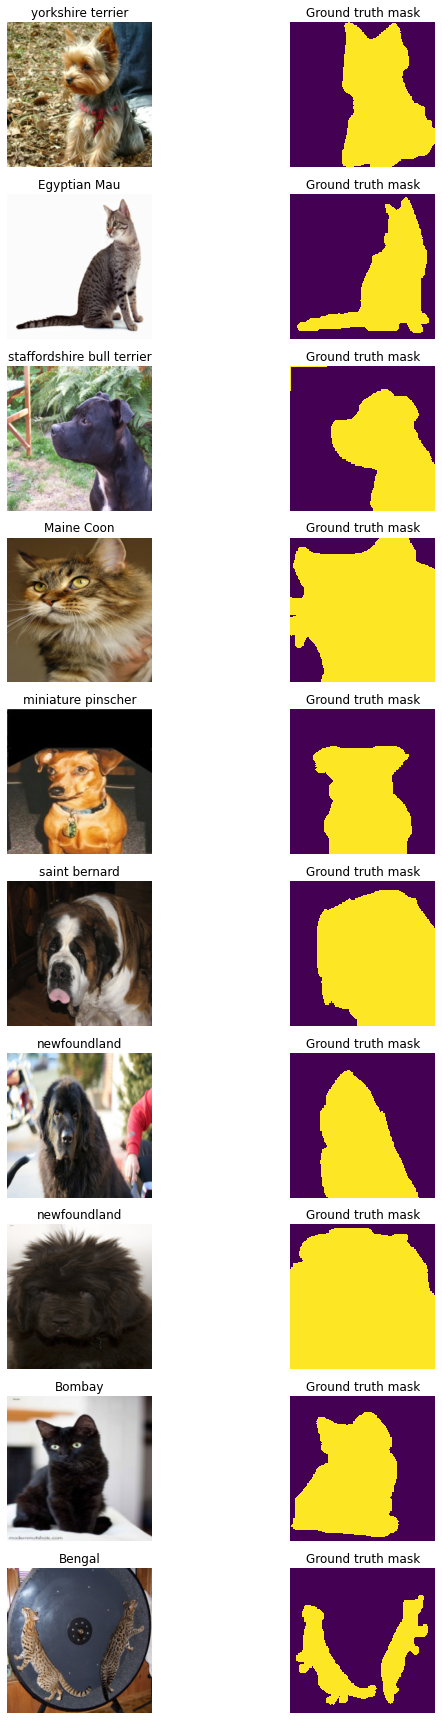

In [8]:
sample_loader = DataLoader(test_data, batch_size = 10, shuffle = True)
images, masks, labels = next(iter(sample_loader))

display_image_grid(images, masks, labels, 10)

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

#### Define functions for device and model loading:

 - FCN ResNet50
 - FCN ResNet101
 - DeepLabV3 ResNet101
 - LR-ASPP MobileNetV3-Large

In [9]:
# Device
def get_device():
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    return device

def get_fcn_resnet50():
    return models.segmentation.fcn_resnet50(pretrained=True).to(get_device())

def get_fcn_resnet101():
    return models.segmentation.fcn_resnet101(pretrained=True).to(get_device())

def get_lraspp_mobilenet_v3_large():
    return models.segmentation.lraspp_mobilenet_v3_large(pretrained=True).to(get_device())

def get_deeplabv3_resnet101():  
    return models.segmentation.deeplabv3_resnet101(pretrained=True).to(get_device())

### Question 1
Describe the main differences between the models you chose.

ADD ANSWER HERE

#### Load the models
Show the architectures

In [10]:
# ADD YOUR CODE HERE

fcn_resnet50              = get_fcn_resnet50()
fcn_resnet101             = get_fcn_resnet101()
lraspp_mobilenet_v3_large = get_lraspp_mobilenet_v3_large()
deeplabv3_resnet101       = get_deeplabv3_resnet101()

## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

**Implement your metrics manually**. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

The dataset contains pixel-level trimap segmentation. For each image, there is an associated PNG file with a mask. The size of a mask equals to the size of the related image. Each pixel in a mask image can take one of three values: 1, 2, or 3. 1 means that this pixel of an image belongs to the class pet, 2 - to the class background, 3 - to the class border. Since we want binary segmentation (that is assigning one of two classes to each pixel), we will preprocess the mask, so it will contain only two uniques values: 0 if a pixel is a background and 1 if a pixel is a pet or a border.

#### Function for predictions

In [11]:
def get_predictions(test_data, model):
    
    device = get_device()
    model  = model
    
    images_tensors = []
    gt_tensors     = []
    output_tensors = []
    test_labels    = []

    test_loader = DataLoader(test_data, batch_size = 150, shuffle = False)

    model.eval()
    for i, (images, masks, labels) in enumerate(test_loader):
        images = images.to(device)

        # Make the predictions for labels across the image
        with torch.no_grad():
            output = model(images)["out"]
            output = output.argmax(1)

        output   = output.cpu().numpy()
        
        images_tensors.append(images.cpu().numpy())
        gt_tensors.append(masks.numpy())
        output_tensors.append(output)
        test_labels.append(labels)
        
    images      = np.concatenate([images_tensors[0], images_tensors[1]], axis = 0)
    predictions = np.concatenate([output_tensors[0], output_tensors[1]], axis = 0)
    gt_masks    = np.concatenate([gt_tensors[0], gt_tensors[1]], axis = 0)
    test_labs   = np.concatenate([test_labels[0], test_labels[1]], axis = 0)

    for i in range(len(output_tensors)):
        
        images      = np.concatenate([images, images_tensors[i]], axis = 0)
        predictions = np.concatenate([predictions, output_tensors[i]], axis = 0)
        gt_masks    = np.concatenate([gt_masks, gt_tensors[i]], axis = 0)
        test_labs    = np.concatenate([test_labs, test_labels[i]], axis = 0)

        
    return images, gt_masks, predictions, test_labs

#### Function for metrics:
 The selected metrics are the following:
  - accuracy
  - recall
  - Dice score
  - IoU
  - Mean Dice score
  - Mean IoU score

In [12]:
def metrics(gt_masks, predictions):
    
    accuracies = []
    recalls    = []
    mean_Dice  = []
    mean_IoU   = []

    for i in range(predictions.shape[0]):

        Y_pred = predictions[i]
        Y_true = gt_masks[i]

        FP = len(np.where(Y_pred - Y_true == -1)[0])
        FN = len(np.where(Y_pred - Y_true == 1)[0])
        TP = len(np.where(Y_pred + Y_true == 2)[0])
        TN = len(np.where(Y_pred + Y_true == 0)[0])

        cmat = [[TP, FN],
                [FP, TN]]

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        recall   = TP / (TP + FN + 1e-8)
        IoU      = TP / (TP + FP + FN)
        Dice     = (2 * TP) / (2 * TP + FP + FN)

        accuracies.append(accuracy)
        recalls.append(recall)
        mean_Dice.append(Dice)
        mean_IoU.append(IoU)
        
    accuracies = np.mean(np.array(accuracies))
    recalls    = np.mean(np.array(recalls))
    mean_Dice  = np.mean(np.array(mean_Dice))
    mean_IoU   = np.mean(np.array(mean_IoU))
    
    return accuracies, recalls, mean_Dice, mean_IoU

def dice_iou_new(gt_masks, predictions):
    num    = predictions.shape[0]
    inputs = predictions.reshape(num, -1)
    target = gt_masks.reshape(num, -1)

    intersection = (inputs * target).sum(1)
    union        = inputs.sum(1) + target.sum(1)
    dice         = (2. * intersection) / (union + 1e-8)
    dice         = dice.sum() / num
    IoU          = (intersection) / (union - intersection)
    IoU          = IoU.sum() / num

    print("Dice", dice)
    print("mean_IoU", IoU)
    
def show_confusion_mat(cmat):
    
    plt.figure(figsize = (6,6))
    sns.heatmap(cmat / np.sum(cmat), cmap = "Reds", annot = True, fmt = '.2%', square = 1,   linewidth = 2.)
    plt.xlabel("predictions")
    plt.ylabel("real values")
    plt.show()

### FCN ResNet50

#### Get the predictions for the mask and post-processing them:
 - Convert the categories from 8 and 12 (cat and dog category in the original model) to 0 and 1

In [13]:
# ADD YOUR CODE HERE

resnet50_images, resnet50_gt_masks, resnet50_predictions, resnet50_test_labels = get_predictions(test_data, fcn_resnet50)
resnet50_predictions                                                           = postprocess_predictions(resnet50_predictions)

print(resnet50_images.shape)
print(resnet50_gt_masks.shape)
print(resnet50_predictions.shape)
print(resnet50_test_labels.shape)

(1520, 3, 224, 224)
(1520, 224, 224)
(1520, 224, 224)
(1520,)


#### Show the metrics results

In [14]:
# ADD YOUR CODE HERE

resnet50_accuracies, resnet50_recalls, resnet50_mean_Dice, resnet50_mean_IoU = metrics(resnet50_gt_masks, resnet50_predictions)

print(f'fcn_resnet50: Accuracy- {resnet50_accuracies * 100}, Recall- {resnet50_recalls * 100}, Mean Dice- {resnet50_mean_Dice * 100}, Mean IoU- {resnet50_mean_IoU * 100}')

fcn_resnet50: Accuracy- 92.51326121525913, Recall- 97.03455508943122, Mean Dice- 87.27351334841657, Mean IoU- 79.6271035197051


### FCN ResNet100

In [15]:
resnet101_images, resnet101_gt_masks, resnet101_predictions, resnet101_test_labels = get_predictions(test_data, fcn_resnet101)
resnet101_predictions                                                              = postprocess_predictions(resnet101_predictions)

In [16]:
resnet101_accuracies, resnet101_recalls, resnet101_mean_Dice, resnet101_mean_IoU = metrics(resnet101_gt_masks, resnet101_predictions)

print(f'Resnet100: Accuracy- {resnet101_accuracies * 100}, Recall- {resnet101_recalls * 100}, Mean Dice- {resnet101_mean_Dice * 100}, Mean IoU- {resnet101_mean_IoU * 100}')

Resnet100: Accuracy- 93.16183612630907, Recall- 97.2978674037303, Mean Dice- 88.23553002314969, Mean IoU- 80.91504213529757


### DeepLabV3

In [17]:
deeplabv3_images, deeplabv3_gt_masks, deeplabv3_predictions, deeplabv3_test_labels = get_predictions(test_data, deeplabv3_resnet101)
deeplabv3_predictions                                                              = postprocess_predictions(deeplabv3_predictions)

In [18]:
deeplabv3_accuracies, deeplabv3_recalls, deeplabv3_mean_Dice, deeplabv3_mean_IoU = metrics(deeplabv3_gt_masks, deeplabv3_predictions)

print(f'DeepLabV3: Accuracy- {deeplabv3_accuracies * 100}, Recall- {deeplabv3_recalls * 100}, Mean Dice- {deeplabv3_mean_Dice * 100}, Mean IoU- {deeplabv3_mean_IoU * 100}')

DeepLabV3: Accuracy- 93.16845362219722, Recall- 96.88905614418131, Mean Dice- 88.45045586316172, Mean IoU- 81.34104883039657


### LR-AASP

In [19]:
lr_aasp_images, lr_aasp_gt_masks, lr_aasp_predictions, lr_aasp_test_labels = get_predictions(test_data, lraspp_mobilenet_v3_large)
lr_aasp_predictions                                                        = postprocess_predictions(lr_aasp_predictions)

In [20]:
lr_aasp_accuracies, lr_aasp_recalls, lr_aasp_mean_Dice, lr_aasp_mean_IoU = metrics(lr_aasp_gt_masks, lr_aasp_predictions)

print(f'LR-AASP: Accuracy- {lr_aasp_accuracies * 100}, Recall- {lr_aasp_recalls * 100}, Mean Dice- {lr_aasp_mean_Dice * 100}, Mean IoU- {lr_aasp_mean_IoU * 100}')

LR-AASP: Accuracy- 87.32796215217174, Recall- 90.91455939241914, Mean Dice- 72.30368628427614, Mean IoU- 63.61617207610168


#### Show some predictions

Original resized image - Grand truth mask - Predicted mask

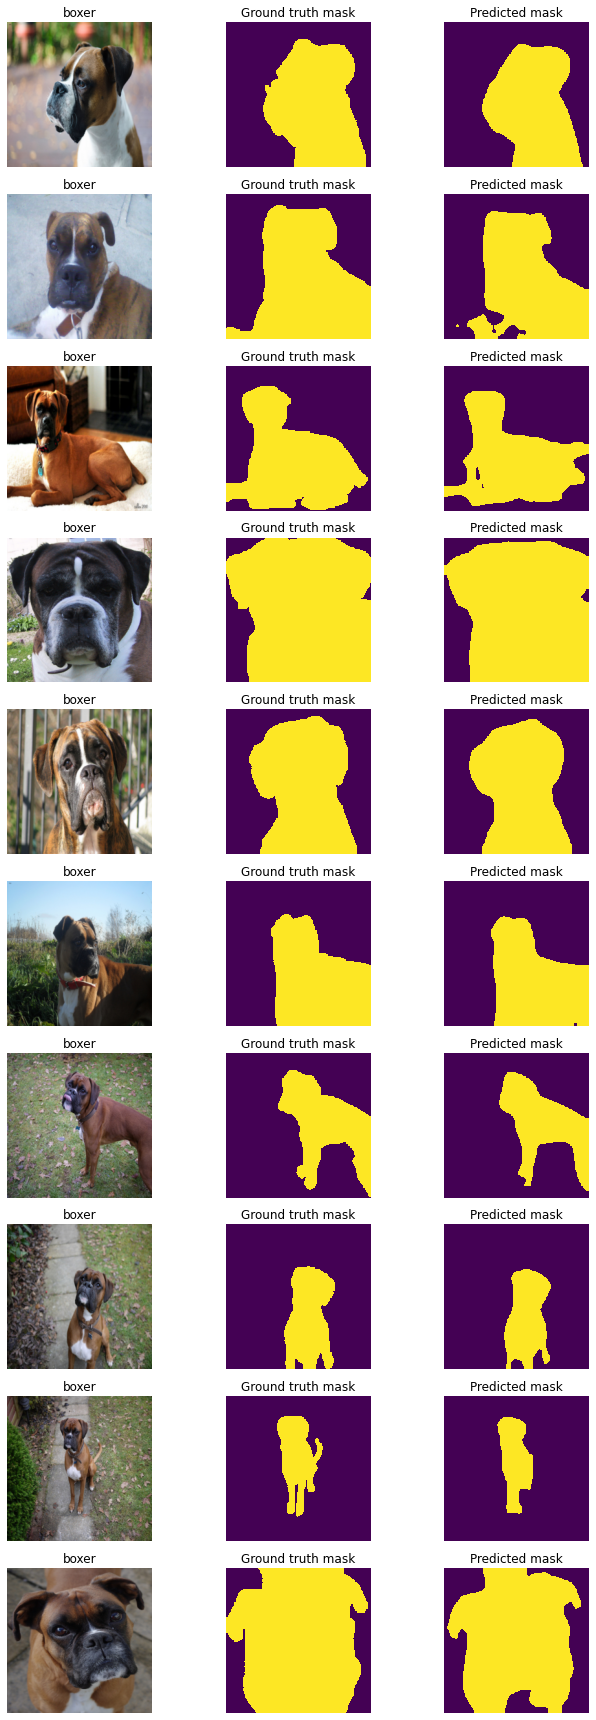

In [21]:
# ADD YOUR CODE HERE

display_image_grid(torch.from_numpy(deeplabv3_images),
                   deeplabv3_gt_masks,
                   deeplabv3_test_labels,
                   10,
                   deeplabv3_predictions)

## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

#### Question 3. 
How could you improve the performance of the models?

ADD ANSWERS HERE